## **Fake News Detector - rozwiązanie konkursowe w ramach kursu Praktyczne Przetwarzanie Języka Naturalnego - DataWorkshop**

link do konkursu: https://www.kaggle.com/c/fake-news-detect?rvi=1

W notebooku przedstawione zostały dwa modele z najwyższym wynikiem według Private Board. Pierwszy z nich wybrałam jako końcowy submit - zarówno na Public Board jak i Private Board osiągnął pierwsze miejsce z wynikiem auc ok. 0.78.


Przygotowanie środowiska, instalacja potrzebnych bibliotek, importy

In [ ]:
!pip install --upgrade tables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = './drive/My Drive/Colab Notebooks/input'

train_dir = f'{data_dir}/train_fake.h5'
test_dir = f'{data_dir}/test_fake.h5'

In [ ]:
!pip install flair
!pip install texthero

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from flair.datasets import ClassificationCorpus
from flair.data import Sentence, Dictionary
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings, FlairEmbeddings, TransformerDocumentEmbeddings, DocumentPoolEmbeddings, TransformerWordEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from torch.optim.adam import Adam
from flair.visual.training_curves import Plotter
import texthero as hero
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial import distance
from html import unescape
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Wczytanie danych**

In [ ]:
df = pd.read_hdf(train_dir) 
test = pd.read_hdf(test_dir) 

In [ ]:
df.fillna('unknown', inplace=True)
test.fillna('unknown', inplace=True)

In [ ]:
df_all = pd.concat([df, test], sort=False)

df_all.shape

(9725, 4)

In [ ]:
df[df['is_fake'] == 1].sample(20)

,id,title,text,is_fake
4004,8111,jobs,Says New Jerseys job growth in May represents ...,1
1487,3013,Somali Immigrant Crashes Car Into Ohio Familie...,unknown,1
3718,7535,candidates-biography,"Say Ohio Reps. Marcia Fudge, Marcy Kaptur and ...",1
4214,8493,"education,jobs,labor","In New York City, an entry level janitor gets ...",1
4373,8813,"religion,terrorism","A sign in Dearborn, Mich., for the Advancement...",1
1101,2237,immigration,"Says that Mitt Romney, while he was in Arizona...",1
1324,2689,"health-care,privacy","A data-storing microchip ""would be implanted i...",1
3693,7480,census,An audit of the last census found that over 37...,1
3861,7832,BREAKING: 60 People Just Found Dead In Ohio,unknown,1
4080,8249,"legal-issues,states","Just on Jan. 1 of this year, there were 40,000...",1


## **Model nr 1**

Model, który zwyciężył zarówno na Public jak i Private Board.
* Public score = 0.78367
* Private score = 0.78480

Uwaga! Kolumny df_all['title'] i df_all['text'] w tym przypadku zostały wykorzystane w surowej postaci - bez preprocessingu. Defaultowy hero preprocessing wykorzystany był tylko do utworzenia kolumny "topic".

**Preprocessing**

In [ ]:
df_all['clean_title'] = hero.clean(df_all['title']) # clean_title przyda się na potrzeby topic modeling

**Topic modeling przy użyciu flair**


In [ ]:
df_all['clean_title'] = df_all['clean_title'].apply(lambda x: x if x != '' else 'stop')

In [ ]:
text = df_all['clean_title']

In [ ]:
def calc_embeddings(text, embeddings):
    sent = Sentence(text)
    embeddings.embed(sent)
    return np.array(sent.embedding.detach().cpu())

In [ ]:
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')
bert_embedding = TransformerWordEmbeddings('distilbert-base-uncased', fine_tune=True)

stacked_embeddings = StackedEmbeddings(
    embeddings=[flair_embedding_forward, flair_embedding_backward, bert_embedding])

embeddings = DocumentRNNEmbeddings([stacked_embeddings])

2020-11-11 00:04:40,640 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpq3ypwto7


100%|██████████| 73034624/73034624 [00:06<00:00, 11693676.31B/s]

2020-11-11 00:04:47,234 copying /tmp/tmpq3ypwto7 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt
2020-11-11 00:04:47,312 removing temp file /tmp/tmpq3ypwto7


2020-11-11 00:05:04,275 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpad_8n64f


100%|██████████| 73034575/73034575 [00:03<00:00, 22503010.77B/s]

2020-11-11 00:05:07,841 copying /tmp/tmpad_8n64f to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2020-11-11 00:05:07,946 removing temp file /tmp/tmpad_8n64f


In [ ]:
df_all['vectors'] = df_all.clean_title.map(lambda text: calc_embeddings(text, embeddings))

In [ ]:
%time df_all['kmeans_k5'] = hero.kmeans(df_all['vectors'], n_clusters=5)

CPU times: user 82.5 ms, sys: 158 ms, total: 240 ms
Wall time: 2.56 s


In [ ]:
df_all['kmeans_k5'].value_counts()

3    3552
0    2650
1    2230
4     832
2     461
Name: kmeans_k5, dtype: int64

In [ ]:
### `Cluster = 0`

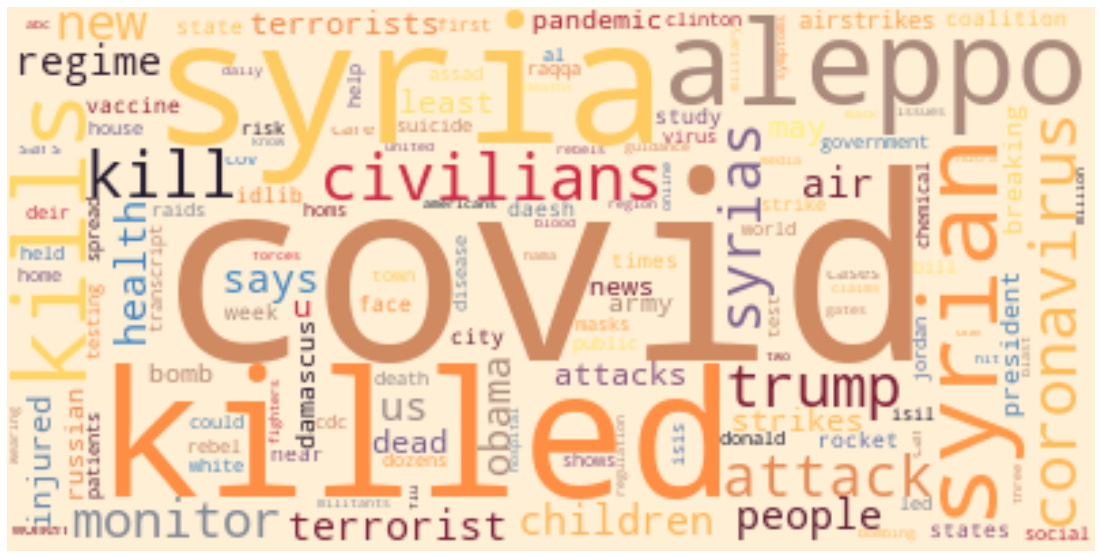

In [ ]:
hero.visualization.wordcloud(df_all[df_all['kmeans_k5'] == 0]['clean_title'])

In [ ]:
hero.visualization.top_words(df_all[df_all['kmeans_k5'] == 0]['clean_title']).head(30)

covid          673
killed         254
syria          250
aleppo         222
syrian         180
kills          155
civilians      154
coronavirus    150
kill           142
trump          130
attack         116
syrias         114
monitor        103
new            100
people          97
terrorist       93
regime          92
children        87
says            86
us              85
obama           82
air             82
health          79
terrorists      78
attacks         78
injured         77
strikes         73
dead            71
u               71
may             70
Name: clean_title, dtype: int64

In [ ]:
### `Cluster = 1`

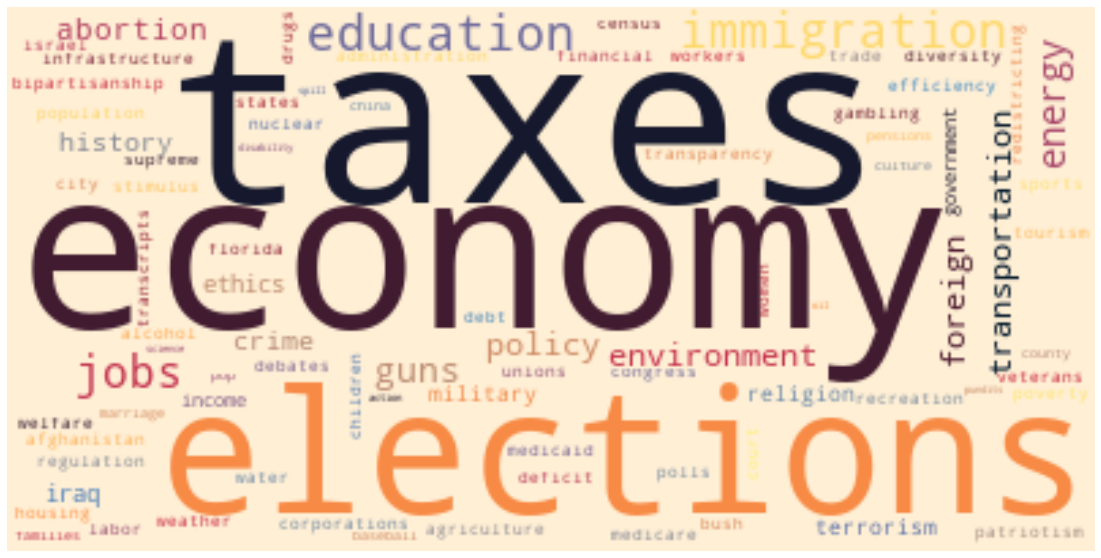

In [ ]:
hero.visualization.wordcloud(df_all[df_all['kmeans_k5'] == 1]['clean_title'])

In [ ]:
hero.visualization.top_words(df_all[df_all['kmeans_k5'] == 1]['clean_title']).head(30)

taxes             253
economy           221
elections         219
immigration       195
education         190
jobs              150
energy            104
guns               85
environment        72
policy             66
transportation     66
foreign            66
abortion           60
crime              53
history            48
ethics             43
iraq               42
terrorism          37
religion           36
military           35
government         28
income             25
workers            20
trade              19
corporations       19
housing            19
sports             18
polls              17
congress           17
labor              17
Name: clean_title, dtype: int64

In [ ]:
### `Cluster = 2`

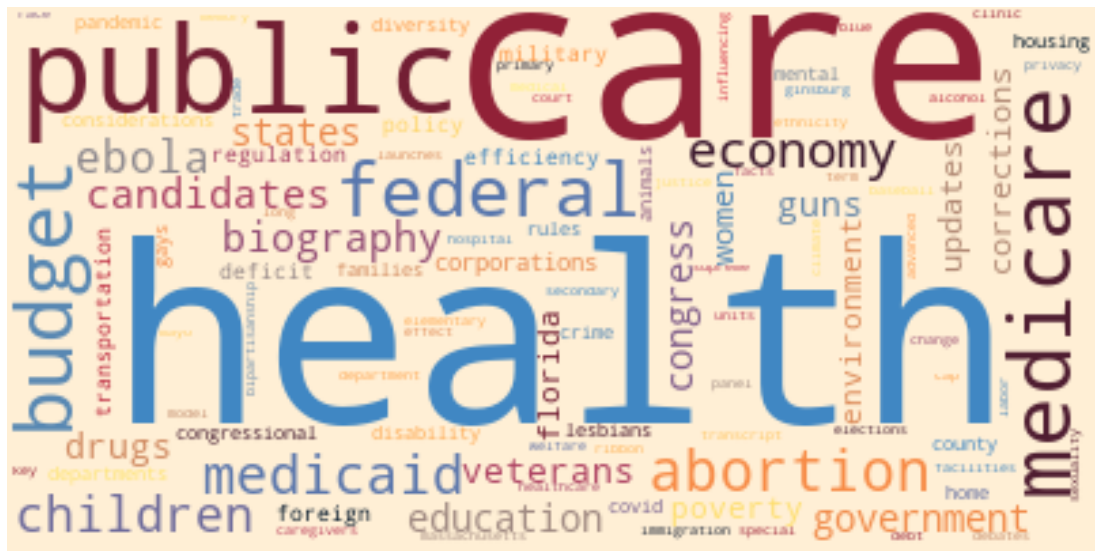

In [ ]:
hero.visualization.wordcloud(df_all[df_all['kmeans_k5'] == 2]['clean_title'])

In [ ]:
hero.visualization.top_words(df_all[df_all['kmeans_k5'] == 2]['clean_title']).head(30)

health          492
care            416
public           77
medicare         30
budget           26
federal          25
abortion         14
medicaid         13
economy          12
children         11
ebola             9
biography         8
candidates        8
states            7
government        7
education         7
congress          7
guns              6
veterans          6
drugs             6
women             5
corrections       5
updates           5
poverty           4
corporations      4
florida           4
environment       4
deficit           3
efficiency        3
policy            3
Name: clean_title, dtype: int64

In [ ]:
### `Cluster = 3`

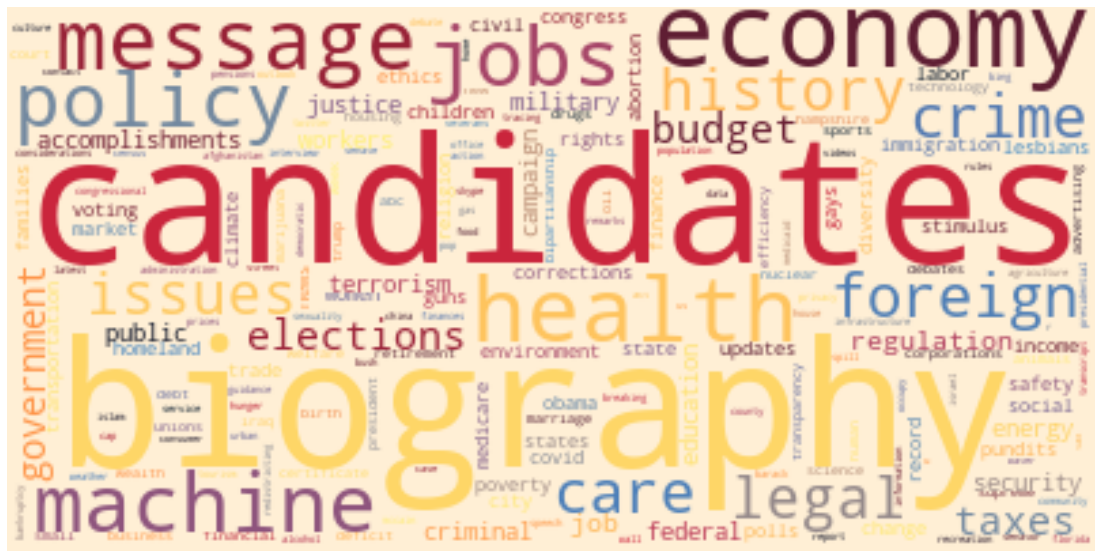

In [ ]:
hero.visualization.wordcloud(df_all[df_all['kmeans_k5'] == 3]['clean_title'])

In [ ]:
hero.visualization.top_words(df_all[df_all['kmeans_k5'] == 3]['clean_title']).head(30)

candidates         397
biography          396
economy            386
health             271
machine            241
message            241
jobs               233
policy             225
foreign            222
care               216
crime              214
history            206
issues             202
legal              201
elections          200
budget             187
taxes              179
government         164
regulation         162
job                158
accomplishments    155
workers            153
military           153
public             152
campaign           147
terrorism          146
justice            146
criminal           145
security           136
federal            130
Name: clean_title, dtype: int64

In [ ]:
### `Cluster = 4`

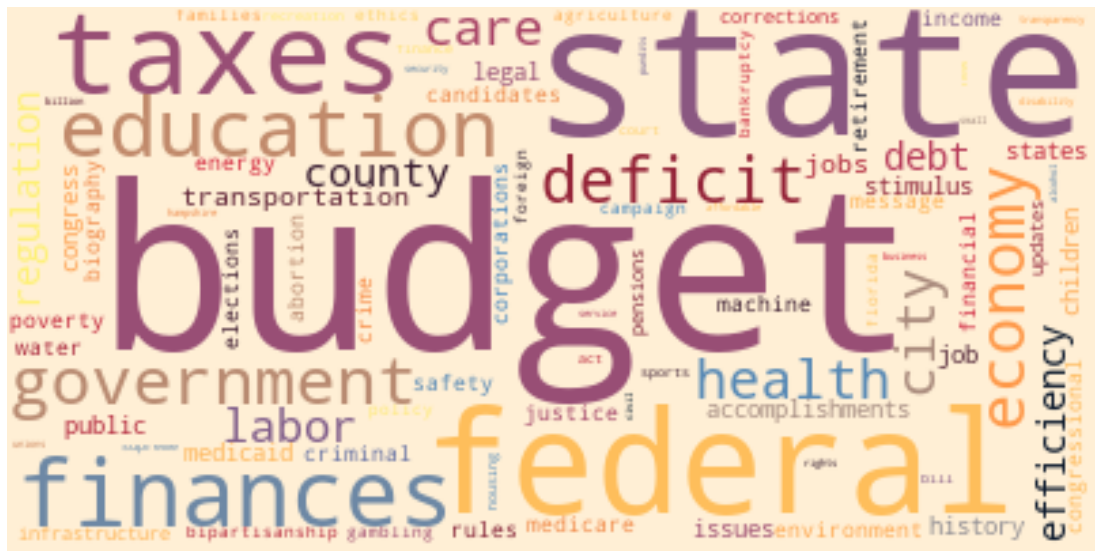

In [ ]:
hero.visualization.wordcloud(df_all[df_all['kmeans_k5'] == 4]['clean_title'])

In [ ]:
hero.visualization.top_words(df_all[df_all['kmeans_k5'] == 4]['clean_title']).head(30)

budget             741
state              533
federal            276
taxes              180
finances           125
education          116
government          96
economy             84
deficit             82
city                64
health              61
care                56
labor               45
county              37
efficiency          32
regulation          31
transportation      31
debt                31
jobs                30
states              24
legal               22
issues              22
history             21
public              20
accomplishments     19
job                 19
stimulus            17
congress            17
medicaid            17
children            16
Name: clean_title, dtype: int64

In [ ]:
df_all.groupby(['is_fake', 'kmeans_k5'])['id'].count()

is_fake  kmeans_k5
0.0      0             836
         1             671
         2             115
         3            1059
         4             248
1.0      0             501
         1             426
         2             127
         3             718
         4             161
Name: id, dtype: int64

In [ ]:
df_all['topic'] = '__topic__' + df_all['kmeans_k5'].astype(str)

In [ ]:
df_all['topic_and_text_with_title'] = df_all['topic'] + ' ' + df_all['title'] + ' ' + df_all['text']

In [ ]:
df = df_all[ ~df_all['is_fake'].isnull() ].copy()
test = df_all[ df_all['is_fake'].isnull() ].copy()

In [ ]:
df['is_fake'] = df['is_fake'].astype(int)

In [ ]:
df_all.head()

,id,title,text,is_fake,clean_title,prep_title,prep_text,vectors,kmeans_k5,topic,topic_and_text_with_title
0,0,"education,message-machine,taxes","There are 321,092 public school teachers in Te...",0.0,education message machine taxes,"education,message-machine,taxes","There are DIGIT,DIGIT public school teachers i...","[-0.97735155, -0.5134311, -0.21145928, 0.82474...",3,__topic__3,"__topic__3 education,message-machine,taxes The..."
1,3,How to cope during the novel coronavirus (COVI...,unknown,0.0,cope novel coronavirus covid pandemic,How to cope during the novel coronavirus (COVI...,unknown,"[-0.99254537, -0.37431693, -0.7325322, -0.9673...",0,__topic__0,__topic__0 How to cope during the novel corona...
2,8,"economy,jobs,women",Under Barack Obama and the big government econ...,1.0,economy jobs women,"economy,jobs,women",Under Barack Obama and the big government econ...,"[-0.9864695, -0.58886224, -0.583572, 0.646103,...",3,__topic__3,"__topic__3 economy,jobs,women Under Barack Oba..."
3,10,jobs,An iron ore mine in northern Wisconsin could o...,0.0,jobs,jobs,An iron ore mine in northern Wisconsin could o...,"[-0.46716762, -0.13494381, 0.43132713, 0.95524...",1,__topic__1,__topic__1 jobs An iron ore mine in northern W...
4,11,COVID-19: Herd immunity may occur sooner than ...,unknown,0.0,covid herd immunity may occur sooner previously,COVID-DIGIT: Herd immunity may occur sooner th...,unknown,"[-0.991604, -0.53039074, -0.1862238, -0.727952...",0,__topic__0,__topic__0 COVID-19: Herd immunity may occur s...


In [ ]:
def save_like_fasttext(text_feat, target_feat, dir_path):

    df['label'] = '__label__' + df['is_fake'].astype(str)

    df[ ['label', text_feat] ].iloc[0:int(len(df)*0.8)].to_csv(dir_path + '/train.txt', sep='\t', index=False, header=False)
    df[ ['label', text_feat] ].iloc[int(len(df)*0.8):int(len(df)*0.9)].to_csv(dir_path + '/test.txt', sep='\t', index=False, header=False)
    df[ ['label', text_feat] ].iloc[int(len(df)*0.9):].to_csv(dir_path + '/dev.txt', sep='\t', index=False, header=False);

In [ ]:
def make_pred(txt):
    sent = Sentence(str(txt))
    classifier.predict(sent)
    return int(sent.labels[0].value)

def make_pred_proba(txt):
    sent = Sentence(str(txt))
    classifier.predict(sent)
    if int(sent.labels[0].value) == 1:
        return sent.labels[0].score
    else:
        return 1 - sent.labels[0].score

In [ ]:
df.head()

,id,title,text,is_fake,clean_title,prep_title,prep_text,vectors,kmeans_k5,topic,topic_and_text_with_title
0,0,"education,message-machine,taxes","There are 321,092 public school teachers in Te...",0,education message machine taxes,"education,message-machine,taxes","There are DIGIT,DIGIT public school teachers i...","[-0.97735155, -0.5134311, -0.21145928, 0.82474...",3,__topic__3,"__topic__3 education,message-machine,taxes The..."
1,3,How to cope during the novel coronavirus (COVI...,unknown,0,cope novel coronavirus covid pandemic,How to cope during the novel coronavirus (COVI...,unknown,"[-0.99254537, -0.37431693, -0.7325322, -0.9673...",0,__topic__0,__topic__0 How to cope during the novel corona...
2,8,"economy,jobs,women",Under Barack Obama and the big government econ...,1,economy jobs women,"economy,jobs,women",Under Barack Obama and the big government econ...,"[-0.9864695, -0.58886224, -0.583572, 0.646103,...",3,__topic__3,"__topic__3 economy,jobs,women Under Barack Oba..."
3,10,jobs,An iron ore mine in northern Wisconsin could o...,0,jobs,jobs,An iron ore mine in northern Wisconsin could o...,"[-0.46716762, -0.13494381, 0.43132713, 0.95524...",1,__topic__1,__topic__1 jobs An iron ore mine in northern W...
4,11,COVID-19: Herd immunity may occur sooner than ...,unknown,0,covid herd immunity may occur sooner previously,COVID-DIGIT: Herd immunity may occur sooner th...,unknown,"[-0.991604, -0.53039074, -0.1862238, -0.727952...",0,__topic__0,__topic__0 COVID-19: Herd immunity may occur s...


In [ ]:
test.head()

,id,title,text,is_fake,clean_title,prep_title,prep_text,vectors,kmeans_k5,topic,topic_and_text_with_title
0,1,environment,"For every [coyote] they kill, the population w...",NaN,environment,environment,"For every [coyote] they kill, the population w...","[-0.4088627, -0.15650879, -0.34195003, 0.90286...",1,__topic__1,__topic__1 environment For every [coyote] they...
1,2,Double bomb attack kills 31 in Syrian Kurdish ...,Wednesday 27 Jul 2016 Double bomb attack kills...,NaN,double bomb attack kills syrian kurdish city s...,Double bomb attack kills DIGIT in Syrian Kurdi...,Wednesday DIGIT Jul DIGIT Double bomb attack k...,"[-0.96403307, -0.25864464, -0.37044704, -0.594...",0,__topic__0,__topic__0 Double bomb attack kills 31 in Syri...
2,4,health-care,"An Iowa policy ""provides for a state round up ...",NaN,health care,health-care,"An Iowa policy ""provides for a state round up ...","[-0.9470423, -0.6175934, -0.003482044, 0.60215...",2,__topic__2,"__topic__2 health-care An Iowa policy ""provide..."
3,5,"health-care,women",A government panel that didn't include cancer ...,NaN,health care women,"health-care,women",A government panel that didn't include cancer ...,"[-0.99189895, -0.64634305, -0.41128638, 0.1646...",2,__topic__2,"__topic__2 health-care,women A government pane..."
4,6,"health-care,medicare,new-hampshire-2012","When the Republicans were in charge, they actu...",NaN,health care medicare new hampshire,"health-care,medicare,new-hampshire-DIGIT","When the Republicans were in charge, they actu...","[-0.5695328, -0.79027504, -0.7207329, 0.621918...",3,__topic__3,"__topic__3 health-care,medicare,new-hampshire-..."


In [ ]:
konkurs_dir = './drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10'

In [ ]:
save_like_fasttext("topic_and_text_with_title", "is_fake", konkurs_dir)

In [ ]:
data_folder = Path(konkurs_dir).resolve()


corpus = ClassificationCorpus(
    data_folder,
    test_file='test.txt',
    dev_file='dev.txt',
    train_file='train.txt')


print(corpus.obtain_statistics())

2020-11-11 00:10:34,568 Reading data from /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10
2020-11-11 00:10:34,569 Train: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/train.txt
2020-11-11 00:10:34,571 Dev: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/dev.txt
2020-11-11 00:10:34,573 Test: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/test.txt
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 3889,
        "number_of_documents_per_class": {
            "0": 2354,
            "1": 1535
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 196691,
            "min": 6,
            "max": 1440,
            "avg": 50.57624067883775
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 486,
        "number_of_documents_per_class": {
            "0": 291,
      

In [ ]:
label_dict = corpus.make_label_dictionary()
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=True)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

2020-11-11 00:10:46,489 Computing label dictionary. Progress:


100%|██████████| 4375/4375 [00:05<00:00, 760.00it/s]

2020-11-11 00:10:52,580 [b'0', b'1']


In [ ]:
trainer.train('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              monitor_train=True)

2020-11-11 00:10:54,258 ----------------------------------------------------------------------------------------------------
2020-11-11 00:10:54,260 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

{'dev_loss_history': [0.5539771318435669,
  0.5625250935554504,
  0.736466109752655,
  1.1438746452331543,
  1.7258108854293823],
 'dev_score_history': [0.7079, 0.7144, 0.7049, 0.6907, 0.7015],
 'test_score': 0.7228,
 'train_loss_history': [tensor(0.4739, device='cuda:0'),
  tensor(0.2842, device='cuda:0'),
  tensor(0.1112, device='cuda:0'),
  tensor(0.0364, device='cuda:0'),
  tensor(0.0197, device='cuda:0')]}

In [ ]:
plotter = Plotter()

2020-11-11 00:23:26,858 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:26,859 WARNING: No LOSS found for test split in this data.
2020-11-11 00:23:26,860 Are you sure you want to plot LOSS and not another value?
2020-11-11 00:23:26,860 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:26,891 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:26,891 WARNING: No F1 found for test split in this data.
2020-11-11 00:23:26,893 Are you sure you want to plot F1 and not another value?
2020-11-11 00:23:26,895 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10/training.png


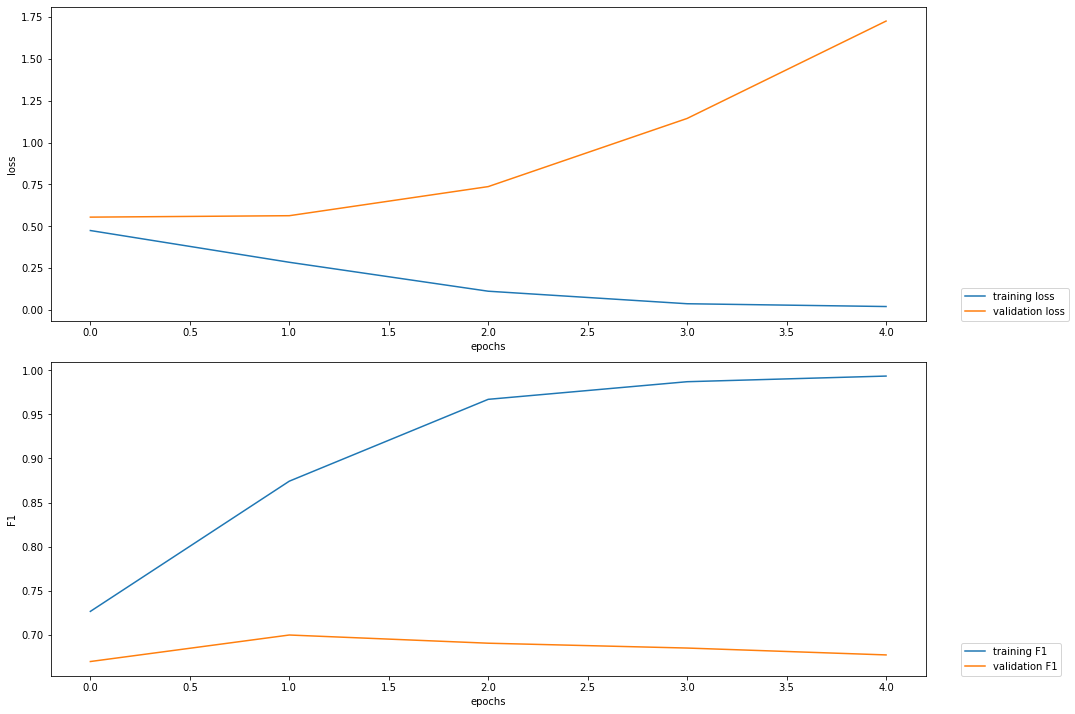

In [ ]:
plotter.plot_training_curves('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10/loss.tsv')

2020-11-11 00:23:29,356 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:29,357 WARNING: No PRECISION found for test split in this data.
2020-11-11 00:23:29,358 Are you sure you want to plot PRECISION and not another value?
2020-11-11 00:23:29,359 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:29,392 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:29,392 WARNING: No RECALL found for test split in this data.
2020-11-11 00:23:29,393 Are you sure you want to plot RECALL and not another value?
2020-11-11 00:23:29,396 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:29,429 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:29,430 WARNING: No ACCURACY 

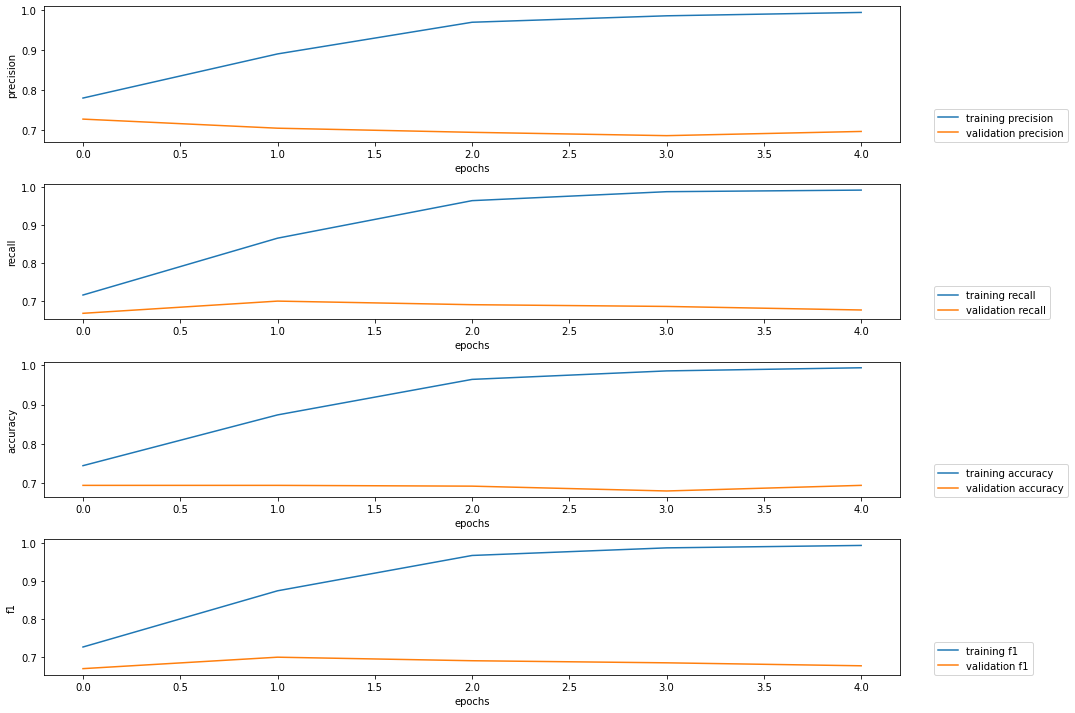

In [ ]:
plotter.plot_training_curves('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10/loss.tsv', ["precision", "recall", "accuracy", "f1"])

In [ ]:
label_dict = corpus.make_label_dictionary()
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

2020-11-11 00:23:32,139 Computing label dictionary. Progress:


100%|██████████| 4375/4375 [00:06<00:00, 695.26it/s]

2020-11-11 00:23:38,815 [b'0', b'1']


In [ ]:
%%time
trainer.train('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              )

2020-11-11 00:23:40,583 ----------------------------------------------------------------------------------------------------
2020-11-11 00:23:40,586 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

{'dev_loss_history': [0.5600169897079468,
  0.5439735054969788,
  0.7712717056274414,
  1.2110259532928467,
  1.8637878894805908],
 'dev_score_history': [0.7002, 0.7166, 0.694, 0.7002, 0.692],
 'test_score': 0.7181,
 'train_loss_history': [0.6022571701877063,
  0.45739528920012906,
  0.2924198239037889,
  0.10989992264406834,
  0.07217017440729676]}

**check AUC with best_model.pt**

In [ ]:
classifier = TextClassifier.load('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10/best-model.pt')

2020-11-11 00:32:02,098 loading file ./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_10/best-model.pt


In [ ]:
validation_test = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/test.txt', sep='\t', header=None)

In [ ]:
validation_test['is_fake'] = validation_test[0].apply(lambda x: x[-1])

In [ ]:
y_true_test = validation_test['is_fake']

In [ ]:
y_true_test = y_true_test.astype(int)

In [ ]:
%time y_pred_test = validation_test[1].map(make_pred)

CPU times: user 4.81 s, sys: 163 ms, total: 4.97 s
Wall time: 4.99 s


In [ ]:
%time y_pred_proba_test = validation_test[1].map(make_pred_proba)

CPU times: user 4.39 s, sys: 111 ms, total: 4.5 s
Wall time: 4.5 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_test, pos_label=1)
metrics.auc(fpr, tpr)

0.6943431139307429

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_proba_test, pos_label=1)
metrics.auc(fpr, tpr)

0.7990483743061063

In [ ]:
validation_dev = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/dev.txt', sep='\t', header=None)

In [ ]:
validation_dev['is_fake'] = validation_dev[0].apply(lambda x: x[-1])

In [ ]:
y_true_dev = validation_dev['is_fake']

In [ ]:
y_true_dev = y_true_dev.astype(int)

In [ ]:
%time y_pred_dev = validation_dev[1].map(make_pred)

CPU times: user 4.3 s, sys: 129 ms, total: 4.43 s
Wall time: 4.43 s


In [ ]:
%time y_pred_proba_dev = validation_dev[1].map(make_pred_proba)

CPU times: user 4.39 s, sys: 117 ms, total: 4.51 s
Wall time: 4.51 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_dev, pos_label=1)
metrics.auc(fpr, tpr)

0.7036529521959343

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_proba_dev, pos_label=1)
metrics.auc(fpr, tpr)

0.7840317768681052

In [ ]:
validation_train = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_10/train.txt', sep='\t', header=None)

In [ ]:
validation_train['is_fake'] = validation_train[0].apply(lambda x: x[-1])

In [ ]:
y_true_train = validation_train['is_fake']

In [ ]:
y_true_train = y_true_train.astype(int)

In [ ]:
%time y_pred_train = validation_train[1].map(make_pred)

CPU times: user 35.7 s, sys: 957 ms, total: 36.6 s
Wall time: 36.6 s


In [ ]:
%time y_pred_proba_train = validation_train[1].map(make_pred_proba)

CPU times: user 35.5 s, sys: 956 ms, total: 36.5 s
Wall time: 36.5 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_train, pos_label=1)
metrics.auc(fpr, tpr)

0.9061360661318042

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_proba_train, pos_label=1)
metrics.auc(fpr, tpr)

0.967928731744982

**Predykcja**

In [ ]:
%time test['is_fake_bin'] = test.topic_and_text_with_title.map(make_pred)

CPU times: user 43 s, sys: 997 ms, total: 44 s
Wall time: 44 s


In [ ]:
%time test['is_fake'] = test.topic_and_text_with_title.map(make_pred_proba)

CPU times: user 43.2 s, sys: 1.04 s, total: 44.2 s
Wall time: 44.2 s


In [ ]:
test[test['is_fake_bin'] == 1].shape

(1789, 12)

In [ ]:
test[ ['id', 'is_fake'] ].to_csv('./drive/My Drive/Colab Notebooks/flair_konkurs_wyniki/prep_custom_hero_flair_distilbert_base_uncased_text_with_title_and_topic_10_best_model.csv', index=False)

## **Model nr 2**

Model, który osiągnął najlepszy wynik na Private Board, ale nie wybrałam go jako final submit, ze względu na słabszy wynik na Public Board
* Public score = 0.76852
* Private score = 0.78814

Ten model nie wykorzystuje topic modelingu, ale za to kolumny title i text zostały poddane preprocessingowi.

**Preprocessing**

Przeglądając dane można zauważyć, że w tytułach pojawiają się pewne słowa występujące tylko w fake newsach najczęściej pisane drukowanymi literami,  np. BREAKING, CONFIRMED, a jeśli cały tytuł jest zapisany wielkimi literami to zawsze jest to fake news.

In [ ]:
df_all[df_all['title'].apply(lambda x: ("BREAKING" in x) | ("CONFIRMED" in x) | x.isupper())]

,id,title,text,is_fake,clean_title
36,89,BREAKING: First NFL Team Declares Bankruptcy O...,unknown,1.0,breaking first nfl team declares bankruptcy kn...
201,413,BREAKING: President Trump Just Told Paul Ryan ...,unknown,1.0,breaking president trump told paul ryan fired
718,1449,CALIFORNIA DEMOCRAT MAXINE WATERS CHARGED ON 3...,unknown,1.0,california democrat maxine waters charged coun...
766,1546,BREAKING: CZECH REPUBLIC ARMS CITIZENS – “YOU ...,unknown,1.0,breaking czech republic arms citizens shoot te...
816,1669,BREAKING: Fox Sports Cancels ALL NFL Broadcast...,unknown,1.0,breaking fox sports cancels nfl broadcasts pla...
...,...,...,...,...,...
3974,7836,MITT ROMNEY: ‘TRUMP HAS SOME VERY SERIOUS EMOT...,unknown,NaN,mitt romney trump serious emotional problems m...
4110,8129,BREAKING: Federal Judge Grants Permission To S...,unknown,NaN,breaking federal judge grants permission subpo...
4469,8888,BREAKING: Johnny Depp Taken Into Custody By Se...,unknown,NaN,breaking johnny depp taken custody secret service
4783,9523,REP. JENKINS: OPIOID CRISIS FUNDING SHOULD BE ...,unknown,NaN,rep jenkins opioid crisis funding based need


Spróbujmy przekształcić tekst tak, aby zastąpić podejrzane słowa słowem "fake"

In [ ]:
df_all['prep_title'] = df_all['title'].str.replace('BREAKING','fake')

In [ ]:
df_all['prep_title'] = df_all['prep_title'].str.replace("CONFIRMED", "fake")

In [ ]:
df_all['prep_title'] = df_all['prep_title'].apply(lambda x: 'fake ' + x if x.isupper() else x)

In [ ]:
df_all[df_all['title'].apply(lambda x: ("BREAKING" in x) | ("CONFIRMED" in x) | x.isupper())]

,id,title,text,is_fake,clean_title,prep_title
36,89,BREAKING: First NFL Team Declares Bankruptcy O...,unknown,1.0,breaking first nfl team declares bankruptcy kn...,fake: First NFL Team Declares Bankruptcy Over ...
201,413,BREAKING: President Trump Just Told Paul Ryan ...,unknown,1.0,breaking president trump told paul ryan fired,fake: President Trump Just Told Paul Ryan ‘You...
718,1449,CALIFORNIA DEMOCRAT MAXINE WATERS CHARGED ON 3...,unknown,1.0,california democrat maxine waters charged coun...,fake CALIFORNIA DEMOCRAT MAXINE WATERS CHARGED...
766,1546,BREAKING: CZECH REPUBLIC ARMS CITIZENS – “YOU ...,unknown,1.0,breaking czech republic arms citizens shoot te...,fake: CZECH REPUBLIC ARMS CITIZENS – “YOU CAN ...
816,1669,BREAKING: Fox Sports Cancels ALL NFL Broadcast...,unknown,1.0,breaking fox sports cancels nfl broadcasts pla...,fake: Fox Sports Cancels ALL NFL Broadcasts ‘U...
...,...,...,...,...,...,...
3974,7836,MITT ROMNEY: ‘TRUMP HAS SOME VERY SERIOUS EMOT...,unknown,NaN,mitt romney trump serious emotional problems m...,fake MITT ROMNEY: ‘TRUMP HAS SOME VERY SERIOUS...
4110,8129,BREAKING: Federal Judge Grants Permission To S...,unknown,NaN,breaking federal judge grants permission subpo...,fake: Federal Judge Grants Permission To Subpo...
4469,8888,BREAKING: Johnny Depp Taken Into Custody By Se...,unknown,NaN,breaking johnny depp taken custody secret service,fake: Johnny Depp Taken Into Custody By Secret...
4783,9523,REP. JENKINS: OPIOID CRISIS FUNDING SHOULD BE ...,unknown,NaN,rep jenkins opioid crisis funding based need,fake REP. JENKINS: OPIOID CRISIS FUNDING SHOUL...


In [ ]:
df_all[df_all['prep_title'].apply(lambda x: x.startswith("UPDATE"))]

,id,title,text,is_fake,clean_title,prep_title
120,262,UPDATE: Florida Governor Rick Scott Now Listed...,unknown,1.0,update florida governor rick scott listed crit...,UPDATE: Florida Governor Rick Scott Now Listed...
2513,5096,UPDATE: Hillary Clinton Leaves The Country As ...,unknown,1.0,update hillary clinton leaves country mueller ...,UPDATE: Hillary Clinton Leaves The Country As ...
4695,9437,UPDATE: Van Full Of Illegals Caught Voting At ...,unknown,1.0,update van full illegals caught voting multipl...,UPDATE: Van Full Of Illegals Caught Voting At ...
1347,2657,UPDATE: Second Roy Moore Accuser Works For Mic...,unknown,NaN,update second roy moore accuser works michelle...,UPDATE: Second Roy Moore Accuser Works For Mic...
4021,7930,UPDATE: Malia Obama Among 10 Arrested In Racis...,unknown,NaN,update malia obama among arrested racist antif...,UPDATE: Malia Obama Among 10 Arrested In Racis...
4395,8730,UPDATED Regime air raids kill 42 near Syria ca...,UPDATED Regime air raids kill 42 near Syria ca...,NaN,updated regime air raids kill near syria capit...,UPDATED Regime air raids kill 42 near Syria ca...


In [ ]:
df_all['prep_title'] = df_all['prep_title'].apply(lambda x: x.replace('UPDATE', 'fake') if x.startswith("UPDATE") else x)

In [ ]:
df_all[df_all['title'].apply(lambda x: x.startswith("UPDATE"))]

,id,title,text,is_fake,clean_title,prep_title
120,262,UPDATE: Florida Governor Rick Scott Now Listed...,unknown,1.0,update florida governor rick scott listed crit...,fake: Florida Governor Rick Scott Now Listed A...
2513,5096,UPDATE: Hillary Clinton Leaves The Country As ...,unknown,1.0,update hillary clinton leaves country mueller ...,fake: Hillary Clinton Leaves The Country As Mu...
4695,9437,UPDATE: Van Full Of Illegals Caught Voting At ...,unknown,1.0,update van full illegals caught voting multipl...,fake: Van Full Of Illegals Caught Voting At Mu...
1347,2657,UPDATE: Second Roy Moore Accuser Works For Mic...,unknown,NaN,update second roy moore accuser works michelle...,fake: Second Roy Moore Accuser Works For Miche...
4021,7930,UPDATE: Malia Obama Among 10 Arrested In Racis...,unknown,NaN,update malia obama among arrested racist antif...,fake: Malia Obama Among 10 Arrested In Racist ...
4395,8730,UPDATED Regime air raids kill 42 near Syria ca...,UPDATED Regime air raids kill 42 near Syria ca...,NaN,updated regime air raids kill near syria capit...,fakeD Regime air raids kill 42 near Syria capi...


Spróbujmy znaleźć inne cechy charakterystyczne dla fake newsów, np czy obecność linków wskazuje na fake newsa.

In [ ]:
df_all[df_all['prep_title'].str.contains(r'https?\S+')]['title'].values

array(['Claim thttps://www.politifact.com/factchecks/2020/may/19/facebook-posts/dr-fauci-didnt-say-americans-should-be-microchippe/hat Dr. Fauci said every American should be microchipped.',
       'Carolyn B. Maloney on Twitter: "Women\'s health & wellbeing don’t seem to count in the math of the GOP\'s merciless #PayMoreForLess healthcare bill. We must not defund @PPFA!… https:'],
      dtype=object)

In [ ]:
df_all[df_all['text'].str.contains(r'https?\S+')]

,id,title,text,is_fake,clean_title,prep_title
128,277,Assad regime helicopter kills 20 people with b...,Published August 27 2016 SEND httpsabahdai.lyp...,0.0,assad regime helicopter kills people barrel bo...,Assad regime helicopter kills 20 people with b...
710,1428,UNICEF says 22 schoolchildren and six teachers...,26 Oct 2016 Air strikes on Syrias opposition-h...,1.0,unicef says schoolchildren six teachers killed...,UNICEF says 22 schoolchildren and six teachers...
1321,2680,Hama Province Syrian Troops Reportedly Kill 30...,29.10.2017(updated 1731 29.10.2017) Get short ...,1.0,hama province syrian troops reportedly kill te...,Hama Province Syrian Troops Reportedly Kill 30...
2309,4688,Syrian regime forces drops vacuum bomb on Idlib,9 Aug 2016 5 people were killed and 12 others ...,1.0,syrian regime forces drops vacuum bomb idlib,Syrian regime forces drops vacuum bomb on Idlib
3149,6365,Syrian Russian air strikes kill 39 civilians i...,13 Jun 2016 Syrian Observatory for Human Right...,0.0,syrian russian air strikes kill civilians idlib,Syrian Russian air strikes kill 39 civilians i...
3648,7363,Syrian warplanes pound Idlib leave 22 dead - D...,Published August 15 2016 SEND httpsabahdai.lyB...,1.0,syrian warplanes pound idlib leave dead daily ...,Syrian warplanes pound Idlib leave 22 dead - D...
3866,7842,DAESH Russia Syrian regime target opposition -...,Published August 15 2016 SEND httpsabahdai.lyr...,0.0,daesh russia syrian regime target opposition d...,DAESH Russia Syrian regime target opposition -...
3896,7902,US jets killed at least 15 civilians in Syria,29 Jul 2016 The US-led coalition strikes came ...,0.0,us jets killed least civilians syria,US jets killed at least 15 civilians in Syria
4132,8353,Air strike on Syrian hospital kills 10 monitor...,Published August 6 2016 SEND httpsabahdai.lyac...,0.0,air strike syrian hospital kills monitoring gr...,Air strike on Syrian hospital kills 10 monitor...
1015,1992,10 civilians killed by Russian air strikes in ...,Published August 2 2016 SEND httpsabahdai.ly9x...,NaN,civilians killed russian air strikes syrias al...,10 civilians killed by Russian air strikes in ...


In [ ]:
df_all[df_all['text'].str.contains(r'https?\S+')]['text'].values

array(['Published August 27 2016 SEND httpsabahdai.lyp3RMJL AA Photo At least 20 people were killed and dozens injured Saturday in a barrel bomb attack carried out by Syrian regime troops in northern Syrias Aleppo province according to a local civil defense official. A regime helicopter struck twice a mourning location in the opposition-held Bab al-Nairab district in Aleppo Ibrahim Abu Leith told Anadolu Agency. "Twenty people were killed and 30 others injured in the attack" he said. According to Abu Leith women and children were among the fatalities. He said the second attack took place when the helicopter dropped another barrel bomb on people who rushed to the scene to help the victims of the first attack. The injured were rushed to field hospitals amid fears that death toll may rise as a number of civilians remain trapped under the debris of their destroyed homes. In recent weeks regime helicopters - along with Russian and Syrian warplanes - have struck a number of marketplaces hosp

Dziwne adresy https występują zarówno w fake newsach jak i w tych prawdziwych. Być może warto to wyczyścić. Przygotujmy również kilka innych funkcji do wyczyszczenia danych.

In [ ]:
def re_urls(text, replace_for="URL"):
    return re.sub(r'https?://\S+', replace_for, text)

def re_https(text, replace_for="URL"):
    return re.sub(r'https?\S+', replace_for, text)

def re_user_mentioned(text, replace_for=r'\1'):
    return re.sub(r'@(\S+)', replace_for, text)

def re_digits(text, replace_for='DIGIT'): 
    result = re.sub(r'\d+', replace_for, text) 
    return result

def re_multi_spaces_into_one(text, replace_for=' '):
    return re.sub(r'\s+', replace_for, text)

def re_topic(text, replace_for=r'\1'):
    return re.sub(r'#(\S+)', replace_for, text)
    
def make_unescape(text):
    return unescape(text) 



def preprocessing(doc):
    doc = make_unescape(doc)
    doc = re_urls(doc)
    doc = re_https(doc)
    doc = re_user_mentioned(doc)
    doc = re_digits(doc)
    doc = re_multi_spaces_into_one(doc)
    doc = re_topic(doc)
    
    return doc

df_all['prep_title'] = df_all['prep_title'].map(preprocessing)
df_all['prep_text'] = df_all['text'].map(preprocessing)

In [ ]:
custom_pipeline = [hero.preprocessing.remove_punctuation,
                   hero.preprocessing.remove_whitespace]

In [ ]:
df_all['title'] = hero.clean(df_all['prep_title'], custom_pipeline)
df_all['text'] = hero.clean(df_all['prep_text'], custom_pipeline)

df_all['text_with_title'] = df_all['title'] + ' ' + df_all['text']

In [ ]:
df = df_all[ ~df_all['is_fake'].isnull() ].copy()
test = df_all[ df_all['is_fake'].isnull() ].copy()

In [ ]:
df['is_fake'] = df['is_fake'].astype(int)

**Text with title**

In [ ]:
konkurs_dir = './drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9'

In [ ]:
save_like_fasttext("text_with_title", "is_fake", konkurs_dir)

In [ ]:
data_folder = Path(konkurs_dir).resolve()


corpus = ClassificationCorpus(
    data_folder,
    test_file='test.txt',
    dev_file='dev.txt',
    train_file='train.txt')


print(corpus.obtain_statistics())

2020-11-09 22:11:07,513 Reading data from /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9
2020-11-09 22:11:07,514 Train: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/train.txt
2020-11-09 22:11:07,515 Dev: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/dev.txt
2020-11-09 22:11:07,515 Test: /content/drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/test.txt
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 3889,
        "number_of_documents_per_class": {
            "0": 2354,
            "1": 1535
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 178644,
            "min": 2,
            "max": 1391,
            "avg": 45.93571612239651
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 486,
        "number_of_documents_per_class": {
            "0": 291,
          

In [ ]:
label_dict = corpus.make_label_dictionary()
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=True)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

2020-11-09 22:11:15,601 Computing label dictionary. Progress:


100%|██████████| 4375/4375 [00:04<00:00, 1006.66it/s]

2020-11-09 22:11:20,088 [b'0', b'1']


In [ ]:
trainer.train('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              monitor_train=True)

2020-11-09 22:11:39,523 ----------------------------------------------------------------------------------------------------
2020-11-09 22:11:39,527 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

{'dev_loss_history': [0.5573522448539734,
  0.6419464945793152,
  0.8872286081314087,
  1.2053320407867432,
  1.7241756916046143],
 'dev_score_history': [0.7024, 0.7078, 0.6963, 0.7, 0.6926],
 'test_score': 0.729,
 'train_loss_history': [tensor(0.4859, device='cuda:0'),
  tensor(0.2725, device='cuda:0'),
  tensor(0.0862, device='cuda:0'),
  tensor(0.0282, device='cuda:0'),
  tensor(0.0073, device='cuda:0')]}

In [ ]:
plotter = Plotter()

2020-11-09 22:22:41,997 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:41,998 WARNING: No LOSS found for test split in this data.
2020-11-09 22:22:41,999 Are you sure you want to plot LOSS and not another value?
2020-11-09 22:22:42,000 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:42,027 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:42,027 WARNING: No F1 found for test split in this data.
2020-11-09 22:22:42,028 Are you sure you want to plot F1 and not another value?
2020-11-09 22:22:42,028 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9/training.png


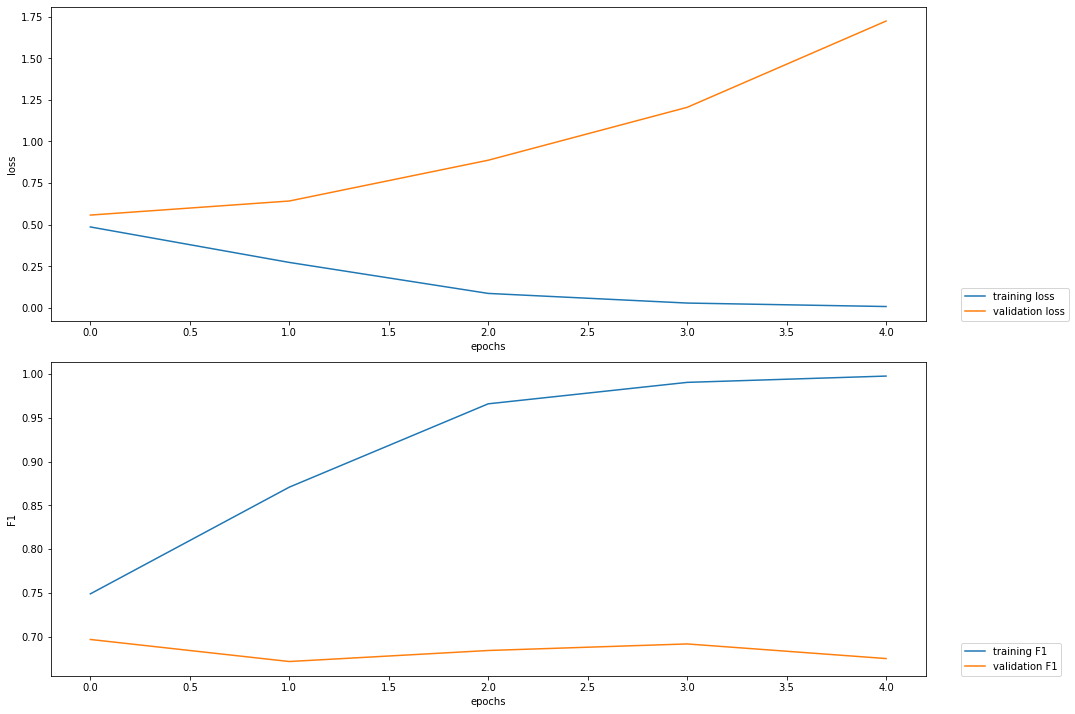

In [ ]:
plotter.plot_training_curves('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9/loss.tsv')

2020-11-09 22:22:44,218 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:44,219 WARNING: No PRECISION found for test split in this data.
2020-11-09 22:22:44,220 Are you sure you want to plot PRECISION and not another value?
2020-11-09 22:22:44,221 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:44,243 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:44,243 WARNING: No RECALL found for test split in this data.
2020-11-09 22:22:44,244 Are you sure you want to plot RECALL and not another value?
2020-11-09 22:22:44,244 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:44,264 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:44,265 WARNING: No ACCURACY 

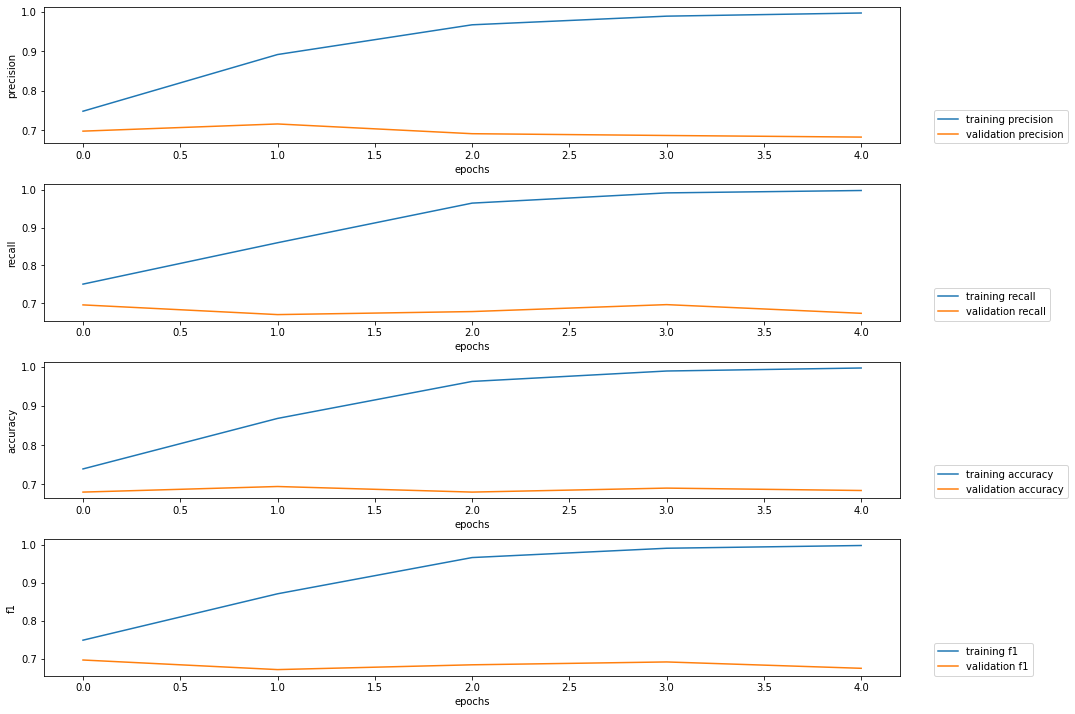

In [ ]:
plotter.plot_training_curves('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9/loss.tsv', ["precision", "recall", "accuracy", "f1"])

In [ ]:
label_dict = corpus.make_label_dictionary()
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

2020-11-09 22:22:47,167 Computing label dictionary. Progress:


100%|██████████| 4375/4375 [00:04<00:00, 912.34it/s] 

2020-11-09 22:22:52,407 [b'0', b'1']


In [ ]:
%%time
trainer.train('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              )

2020-11-09 22:22:53,959 ----------------------------------------------------------------------------------------------------
2020-11-09 22:22:53,961 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

{'dev_loss_history': [0.5724533200263977,
  0.6242581605911255,
  0.7545449733734131,
  1.452714443206787,
  2.0088775157928467],
 'dev_score_history': [0.6653, 0.7331, 0.6899, 0.7105, 0.6879],
 'test_score': 0.7243,
 'train_loss_history': [0.589279076069227,
  0.47319976240253364,
  0.3129981109623408,
  0.11358484048758731,
  0.06658628425191858]}

**check AUC with best_model.pt**

In [ ]:
classifier = TextClassifier.load('./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9/best-model.pt')

2020-11-09 22:30:56,657 loading file ./drive/My Drive/Colab Notebooks/fake_news/konkurs_models/fake_news_text_with_title_9/best-model.pt


In [ ]:
validation_test = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/test.txt', sep='\t', header=None)

In [ ]:
validation_test['is_fake'] = validation_test[0].apply(lambda x: x[-1])

In [ ]:
y_true_test = validation_test['is_fake']

In [ ]:
y_true_test = y_true_test.astype(int)

In [ ]:
%time y_pred_test = validation_test[1].map(make_pred)

CPU times: user 4.4 s, sys: 171 ms, total: 4.57 s
Wall time: 4.59 s


In [ ]:
%time y_pred_proba_test = validation_test[1].map(make_pred_proba)

CPU times: user 4.15 s, sys: 98.8 ms, total: 4.25 s
Wall time: 4.25 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_test, pos_label=1)
metrics.auc(fpr, tpr)

0.6877081681205393

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pred_proba_test, pos_label=1)
metrics.auc(fpr, tpr)

0.7906599700414134

In [ ]:
validation_dev = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/dev.txt', sep='\t', header=None)

In [ ]:
validation_dev['is_fake'] = validation_dev[0].apply(lambda x: x[-1])

In [ ]:
y_true_dev = validation_dev['is_fake']

In [ ]:
y_true_dev = y_true_dev.astype(int)

In [ ]:
%time y_pred_dev = validation_dev[1].map(make_pred)

CPU times: user 4.12 s, sys: 138 ms, total: 4.25 s
Wall time: 4.26 s


In [ ]:
%time y_pred_proba_dev = validation_dev[1].map(make_pred_proba)

CPU times: user 4.13 s, sys: 131 ms, total: 4.26 s
Wall time: 4.26 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_dev, pos_label=1)
metrics.auc(fpr, tpr)

0.7008776798723375

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_dev, y_pred_proba_dev, pos_label=1)
metrics.auc(fpr, tpr)

0.795739956983279

In [ ]:
validation_train = pd.read_csv('./drive/My Drive/Colab Notebooks/fake_news/text_with_title_train_9/train.txt', sep='\t', header=None)

In [ ]:
validation_train['is_fake'] = validation_train[0].apply(lambda x: x[-1])

In [ ]:
y_true_train = validation_train['is_fake']

In [ ]:
y_true_train = y_true_train.astype(int)

In [ ]:
%time y_pred_train = validation_train[1].map(make_pred)

CPU times: user 33.1 s, sys: 1.01 s, total: 34.1 s
Wall time: 34.1 s


In [ ]:
%time y_pred_proba_train = validation_train[1].map(make_pred_proba)

CPU times: user 32.7 s, sys: 938 ms, total: 33.7 s
Wall time: 33.7 s


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_train, pos_label=1)
metrics.auc(fpr, tpr)

0.8597530297034086

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_proba_train, pos_label=1)
metrics.auc(fpr, tpr)

0.9643799866607258

**Predykcja**

In [ ]:
%time test['is_fake_bin'] = test.text_with_title.map(make_pred)

CPU times: user 40.4 s, sys: 1.16 s, total: 41.6 s
Wall time: 41.6 s


In [ ]:
%time test['is_fake'] = test.text_with_title.map(make_pred_proba)

CPU times: user 40.8 s, sys: 1.13 s, total: 42 s
Wall time: 42 s


In [ ]:
test[test['is_fake_bin'] == 1].shape

(1274, 8)

In [ ]:
test[ ['id', 'is_fake'] ].to_csv('./drive/My Drive/Colab Notebooks/flair_konkurs_wyniki/custom_hero_flair_distilbert_base_uncased_text_with_title_9_best_model.csv', index=False)